In this exercise session, we'll walk through fitting some Gaussian Process regression models to an HCI dataset - touch offsets. The data consists of around 1000 touches for each of 8 users on a Nokia N9 smartphone. For each touch, the user was shown a crosshair and asked to touch it as accurately as possible.

We have two values for each touch - the position the target was shown, and the location recorded by the phone when the user actually touched. These are not the same. There exist systematic offsets between the intended and actual touch locations. It's these offsets that we're going to try and predict. 

First, some imports and ipython housekeeping.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import pickle

%matplotlib inline

Let's try and load some data. Note that the axes are in the wrong order, so we use np.fliplr to fix them.

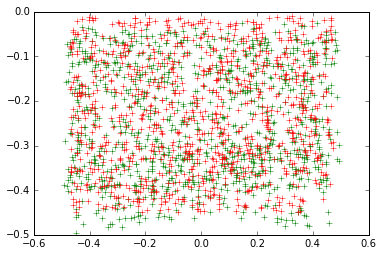

In [37]:
with open('touchdata.obj','r') as f:
    userdata = pickle.load(f)
    
u0 = userdata[0] #Get the data for only the first user
pos = np.fliplr(u0['pos']) #Device locations
target = np.fliplr(u0['target']) #Intended targets

plt.plot(pos[:,0],pos[:,1],'g+') 
plt.plot(target[:,0], target[:,1],'r+')

A couple of things to note:

1) Data are all in the lower half of the screen - study was intended to look at offsets in the region occupied by the keyboard.

2) Clearly, the targets and touch locations are offset from each other.

We want to predict the offset between pos and target, so let's get that as a variable. Note that we'll need to train separate models for the x- and y-offsets.

In [38]:
x_offset = target[:,0] - pos[:,0]
y_offset = target[:,1] - pos[:,1]

Remember, it's important to have a test set. Let's separate some data out.

In [39]:
indices = np.random.permutation(pos.shape[0]) #Get a random permutation of the numbers up to the size of the data
n_train = np.floor(0.8*pos.shape[0]) #Use 80% of the data to train, the rest to test.

trainind = indices[:n_train]
testind = indices[n_train:]


Let's try and get a baseline error for our predictions. We'll use the RMSE between the test subset of pos and target.

In [51]:
def RMSE(pred, targets):
    return np.sqrt(np.mean((pred-targets)**2))

pos_test = pos[testind,:]
tar_test = target[testind,:]
baseline_error =  RMSE(pos_test, tar_test)
print baseline_error

0.0233750883973


OK, let's actually try and train a GP on our data. In fact, we'll train two.

In [42]:
#Set up the kernels - we'll start with a very basic Gaussian kernel
x_kern = GPy.kern.RBF(input_dim = 2)
y_kern = GPy.kern.RBF(input_dim = 2)

#Get the training data
pos_train = pos[trainind,:]
x_train = x_offset[trainind,None]
y_train = y_offset[trainind,None]

#Set up the models
x_model = GPy.models.GPRegression(pos_train, x_train, x_kern)
y_model = GPy.models.GPRegression(pos_train, y_train, y_kern)

#Constrain things to be positive - don't want lengthscales etc to be negative
x_model.constrain_positive('.*')
y_model.constrain_positive('.*')

#Optimise the covariance hyperparameters
x_model.optimize()
y_model.optimize()

print 'Done' #Can take a while

Done


Let's try and visualise the offsets we got in the x-dimension.

{'contour': <matplotlib.contour.QuadContourSet instance at 0x7f6160a30cf8>,
 'dataplot': <matplotlib.collections.PathCollection at 0x7f61609ffc90>}

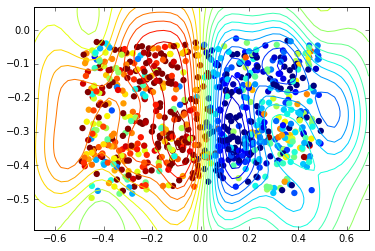

In [43]:
x_model.plot()

There's interesting structure here! There's a point in the middle of the screen where the offset direction changes rapidly. This is where the user switched from one thumb to the other - the left thumb touched to the left of the target, and the right one to the right.

Further, the offset surface is highly nonlinear - within a single thumb, there's still a lot of variation.

Now let's get the predicted offsets at our test points.

In [55]:
x_pred = x_model.predict(pos_test)[0]
y_pred = y_model.predict(pos_test)[0]

#Add the predicted offset to the test points to get a predicted target
pred2d = np.hstack([x_pred, y_pred])
pred_loc = pred2d + pos_test

#Compute the error
gp_error = RMSE(pred_loc, tar_test)
print 'GP RMSE = %.5f, Baseline = %.5f (lower is better)' % (gp_error, baseline_error)

GP RMSE = 0.01731, Baseline = 0.02338 (lower is better)


Hard to tell what this means. The data are all scaled into a unit square - let's convert back to the physical dimensions of the phone to see how big this effect is.

In [61]:
pred_mm = (pred_loc+[0.5,0.5])*[854,480]
tar_mm = (tar_test+[0.5,0.5])*[854,480]
pos_mm = (pos_test+[0.5,0.5])*[854,480]

gp_error_mm = RMSE(pred_mm,tar_mm)
baseline_mm = RMSE(pos_mm,tar_mm)
print 'GP RMSE = %.5f, Baseline = %.5f (lower is better)' % (gp_error_mm, baseline_mm)


GP RMSE = 10.77056, Baseline = 15.21019 (lower is better)


So, on average the GP predictions are 10 pixels from the true targets, while the phone's recorded touches are 15 pixels away. The distances are small, but when interface elements are densely packed, even a small improvement can prevent errors. A good example of this is on a soft keyboard.

**Exercises**

1) Try training models using some other users' data. How are the offset patterns different?

2) Try training a model for one user and testing on another user's data. How do the results compare to training on the second user's own data.

3) Can you get better predictions using some other covariance function?